In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_dir = 'Data/ml-25m/'
df_genomes = pd.read_csv(base_dir+'genome-scores.csv')
df_ratings = pd.read_csv(base_dir+'ratings.csv')

Things to analyse:
1. Which movie comes after certain time?

    <p>Movies could be released from a certain time, if we split ratings simply by time some movies may not been released at that time. One possibile problem is that if we cut at a time, for ecample 1 Jan 2019, movies released after that time will not be recorded in the data base.</p>
 
2. Distributions of times of reviews by movie.

    <p>Each movie has different release times which means we could not have a golbal timestamp to cut the data since we could possibile lost import rating data of some movies and overweight sone older movies.</p>
 
3. Conclusion: Although it may seems better to cut by user and movies. Randomly select some movies of some user to test the effect of recommender sysrtem.
    
    <p>Releastic problem: we always need to find some connections between user and movie in real applications.</p>
   

In [3]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [140]:
print(len(df_ratings))

25000095


In [5]:
rate_by_user = df_ratings['userId'].value_counts()

In [31]:
print('Minium rating number is '+str(rate_by_user.min())+'. Maximum rating number is '+str(rate_by_user.max()))

Minium rating number is 20. Maximum rating number is 32202


In [33]:
print('Mean rating number is '+str(rate_by_user.mean())+'. Medium rating number is '+str(rate_by_user.median()))

Mean rating number is 153.80793153727367. Medium rating number is 71.0


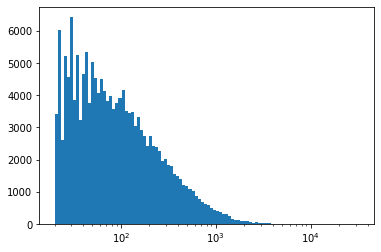

In [35]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

plot_loghist(rate_by_user, 100)
plt.show()

In [4]:
rate_by_movie = df_ratings['movieId'].value_counts()

In [10]:
def printStats(df):
    dmin = df.min()
    dmax = df.max()
    dmean = df.mean()
    dmedian = df.median()
    print('Minium rating number is '+str(dmin)+'. Maximum rating number is '+str(dmax))
    print('Mean rating number is '+str(dmean)+'. Medium rating number is '+str(dmedian))

In [37]:
print('Minium rating number is '+str(rate_by_movie.min())+'. Maximum rating number is '+str(rate_by_movie.max()))

Minium rating number is 1. Maximum rating number is 81491


In [38]:
print('Mean rating number is '+str(rate_by_movie.mean())+'. Medium rating number is '+str(rate_by_movie.median()))

Mean rating number is 423.3931444442563. Medium rating number is 6.0


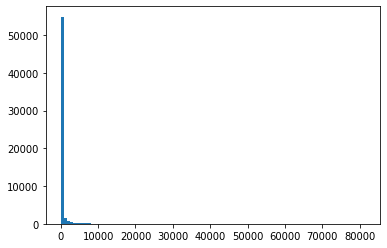

In [39]:
plt.hist(rate_by_movie,100)
plt.show()

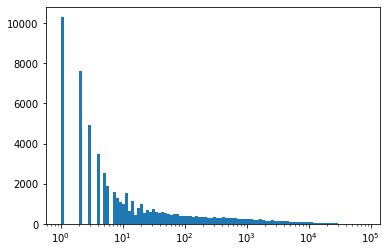

In [43]:
plot_loghist(rate_by_movie,100)

In [41]:
rate_by_movie

356       81491
318       81482
296       79672
593       74127
2571      72674
          ...  
142782        1
63141         1
135021        1
206712        1
190761        1
Name: movieId, Length: 59047, dtype: int64

Only with ratings >5, 8:2 split is applicable. We still need to check if some users were dropped due to this procedure

In [6]:
long_ratings = rate_by_movie[rate_by_movie>=5]
print(len(long_ratings))

32720


Near 27000 movies were filtered. At most 140000 ratings lost, that's about 5% of orginal data.

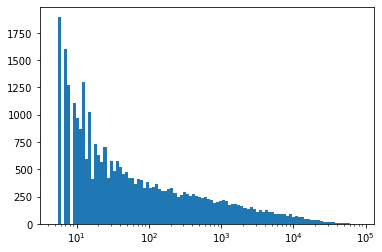

In [46]:
plot_loghist(long_ratings,100)

In [7]:
filtered_movies = long_ratings.index.values.tolist()
print(len(filtered_movies))

32720


In [8]:
ratings_filtered = df_ratings[df_ratings['movieId'].isin(filtered_movies)]

Only 54225 ratings changed.

In [141]:
print(len(df_ratings)-len(ratings_filtered))

54225


As observed, lost is not significant

In [11]:
rate_by_userf = ratings_filtered['userId'].value_counts()
print(len(rate_by_userf))
printStats(rate_by_userf)

162541
Minium rating number is 11. Maximum rating number is 22348
Mean rating number is 153.47432340148023. Medium rating number is 71.0


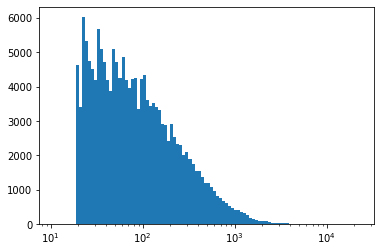

In [60]:
plot_loghist(rate_by_userf,100)

In [12]:
ratings_filtered.to_csv(base_dir+'rating_filtered.csv')

In [13]:
ratings_filtered.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Plot time distribution of user ratings

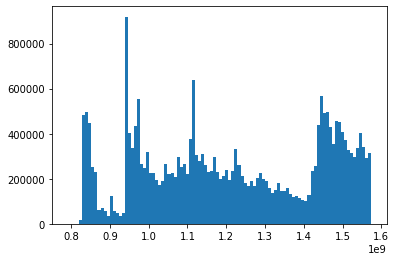

In [64]:
plt.hist(ratings_filtered['timestamp'],100)
plt.show()

Group user by time stamp then get median of each user and extract a subset of the dataset.

In [68]:
printStats(df_ratings['timestamp'])

Minium rating number is 789652009. Maximum rating number is 1574327703
Mean rating number is 1215601443.12155. Medium rating number is 1198868375.0


In [14]:
from datetime import datetime
def convertTime(ts):
    print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

Earlyest, median and latest rating time

In [71]:
convertTime(1198868375)

2007-12-28 18:59:35


In [72]:
convertTime(1574327703)

2019-11-21 09:15:03


In [73]:
convertTime(789652009)

1995-01-09 11:46:49


Plan: split rating by each user, apply it to 80% quantile by rating time
Problem: some movies may not present in user rating, since they are presented at last 20% time.

In [9]:
qTest = ratings_filtered[['userId','timestamp']].groupby('userId').quantile(0.8)

In [96]:
print(qTest.loc[qTest['timestamp']>1000000])

           timestamp
userId              
1       1.147879e+09
2       1.141417e+09
3       1.566090e+09
4       1.573943e+09
5       8.586276e+08
...              ...
162537  1.047172e+09
162538  1.438784e+09
162539  9.951506e+08
162540  1.248862e+09
162541  1.240953e+09

[162541 rows x 1 columns]


In [10]:
def splitByQuantile(df,quantile,ctr):
    startIdx = 1
    idxTrain = []
    idxTest = []
    for idx, udata in df.iterrows():
        # Assume rating data is well sorted
        if udata['userId'] != startIdx:
            startIdx = udata['userId']
        if udata[ctr] >= quantile[ctr][startIdx]:
            idxTest.append(idx)
        else:
            idxTrain.append(idx)
    return idxTrain, idxTest

In [11]:
trainIndexes, testIndexes = splitByQuantile(ratings_filtered, qTest, 'timestamp')

In [116]:
print(type(testIndexes)

<class 'list'>


In [13]:
def getDataByIdx(df,idxList):
    return(df.loc[idxList])

In [14]:
train_set = getDataByIdx(ratings_filtered, trainIndexes)
test_set = getDataByIdx(ratings_filtered, testIndexes)

Goal: sample dataset by randomusers.

In [20]:
train_set.head()

,userId,movieId,rating,timestamp
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826


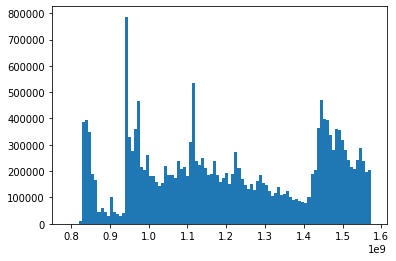

In [121]:
plt.hist(train_set['timestamp'],100)
plt.show()

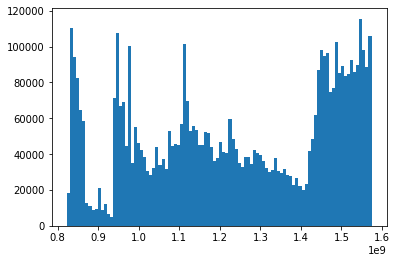

In [122]:
plt.hist(test_set['timestamp'],100)
plt.show()

In [21]:
tags = pd.read_csv(base_dir+'tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [24]:
tagcounts = tags['tag'].value_counts()
print(tagcounts)

sci-fi                       8330
atmospheric                  6516
action                       5907
comedy                       5702
surreal                      5326
                             ... 
fairy tale:The White Cat        1
lullaby                         1
Shine On by needtobreathe       1
sissy spacek                    1
Peter Mortimer                  1
Name: tag, Length: 73050, dtype: int64


As we can see, tag is a sparse feature.

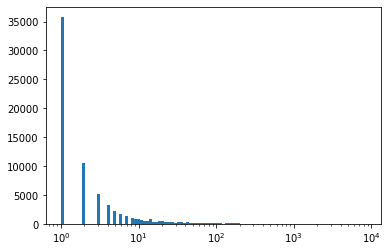

In [134]:
plot_loghist(tagcounts,100)

Question: wether every movie in ratings data has at least one tag?

In [22]:
badMovie = ratings_filtered[~ratings_filtered['movieId'].isin(tags['movieId'])]

Unfortunately some (around 3935) 'bad movies' exist. Around 58000 ratings. It is pitty to drop those data.

In [139]:
print(badMovie['movieId'].value_counts())

3943      724
1600      626
603       569
5584      503
463       369
         ... 
205257      5
177709      5
182535      5
199940      5
207343      5
Name: movieId, Length: 3935, dtype: int64


Question: if filtered by count of tags, how many ratings will be filtered.

In [25]:
tagcountsfrq = tagcounts[tagcounts>600]
printStats(tagcountsfrq)
print(tagcountsfrq)

Minium rating number is 601. Maximum rating number is 8330
Mean rating number is 1524.26953125. Medium rating number is 1046.0
sci-fi             8330
atmospheric        6516
action             5907
comedy             5702
surreal            5326
                   ... 
Robert De Niro      613
Robin Williams      611
cheesy              608
plot holes          603
Stanley Kubrick     601
Name: tag, Length: 256, dtype: int64


In [26]:
frq_tags = tags[tags['tag'].isin(tagcountsfrq.index.values.tolist())]

Price is too high, lost 410428 data

In [27]:
worseMovie = ratings_filtered[~ratings_filtered['movieId'].isin(frq_tags['movieId'])]
print(worseMovie)

          userId  movieId  rating   timestamp
123            2     1465     3.0  1141417875
234            2     8010     5.0  1141417603
321            3     2938     4.0  1484754240
893            3   151763     4.0  1484754009
982            4     7324     3.0  1573940718
...          ...      ...     ...         ...
24999556  162537     1593     3.0  1047171112
24999586  162537     2876     3.0  1047171755
24999604  162537     4141     4.0  1047171650
24999610  162537     4757     5.0  1047171375
24999614  162537     5213     1.0  1047171695

[410428 rows x 4 columns]


In [28]:
train_set.to_csv(base_dir+'train.csv')
test_set.to_csv(base_dir+'test.csv')

In [31]:
genome_tags = pd.read_csv(base_dir+'genome-tags.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [33]:
print(len(genome_tags))

1128


In [18]:
genome_scores = pd.read_csv(base_dir+'genome-scores.csv')

In [35]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [37]:
print(len(genome_scores)/1128)

13816.0


In [19]:
genome_cnts = genome_scores['movieId'].value_counts()
print(len(genome_cnts))

13816


Know how much total price paid if 'reduce data': data lost around 1.5%

In [20]:
genomed_movies = ratings_filtered[ratings_filtered['movieId'].isin(genome_cnts.index.values.tolist())]
print(len(genomed_movies)/len(df_ratings))

0.9869607695490757


In [53]:
printStats(genomed_movies['userId'].value_counts())
printStats(genomed_movies['movieId'].value_counts())

Minium rating number is 5. Maximum rating number is 10988
Mean rating number is 151.80332841146796. Medium rating number is 71.0
Minium rating number is 33. Maximum rating number is 81491
Mean rating number is 1785.9085842501447. Medium rating number is 288.0


Rebuild train-test set.

In [21]:
qTestf = genomed_movies[['userId','timestamp']].groupby('userId').quantile(0.8)

In [66]:
print(qTestf)

           timestamp
userId              
1       1.147879e+09
2       1.141417e+09
3       1.566090e+09
4       1.573943e+09
5       8.586276e+08
...              ...
162537  1.047172e+09
162538  1.438784e+09
162539  9.951506e+08
162540  1.248862e+09
162541  1.240953e+09

[162540 rows x 1 columns]


In [22]:
trainIndexes, testIndexes = splitByQuantile(genomed_movies, qTestf, 'timestamp')

In [23]:
train_set = getDataByIdx(genomed_movies, trainIndexes)
test_set = getDataByIdx(genomed_movies, testIndexes)

In [29]:
print(genomed_movies.head())

   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


In [34]:
count_by_movie = genomed_movies['movieId'].value_counts()

In [36]:
genome_cnts.to_csv(base_dir+'surived_movies.csv')

In [42]:
top_ratingusers = genomed_movies['userId'].value_counts()
user_ids = top_ratingusers.index.values.tolist()
print(top_ratingusers)

72315     10988
80974      7036
20055      6940
33844      6340
92046      5925
          ...  
16557        11
84947        10
144931        6
10861         6
122860        5
Name: userId, Length: 162540, dtype: int64


In [44]:
top5000 = user_ids[:5000]
top5000_ratings = genomed_movies[genomed_movies['userId'].isin(top5000)]
print(len(top5000_ratings))
top5000_ratings.head()

5925941


,userId,movieId,rating,timestamp
1714,12,1,4.0,1167582601
1715,12,2,2.0,968257492
1716,12,3,2.0,1137231033
1717,12,7,3.0,940802609
1718,12,10,3.0,940791277


In [45]:
qTest5000 = top5000_ratings[['userId','timestamp']].groupby('userId').quantile(0.8)

In [47]:
top5000_ratings.to_csv('Data/User_data/top5000.csv')

In [49]:
train_5000, test_5000 = splitByQuantile(top5000_ratings, qTest5000, 'timestamp')
train_set_5000 = getDataByIdx(top5000_ratings, train_5000)
test_set_5000 = getDataByIdx(top5000_ratings, test_5000)
train_set_5000.to_csv('Data/User_data/train_5000.csv')
test_set_5000.to_csv('Data/User_data/test_5000.csv')

In [51]:
div5000 = len(top_ratingusers)//5000
def synPartion(idx, div):
    selected = []
    for i in range(0,len(idx),div):
        selected.append(idx[i])
    return selected
syn5000 = synPartion(user_ids, div5000)

In [53]:
syn_5000_ratings = genomed_movies[genomed_movies['userId'].isin(syn5000)]
print(len(syn_5000_ratings))
syn_5000_ratings.tail()

779035


,userId,movieId,rating,timestamp
24999373,162534,192379,3.5,1542036535
24999374,162534,193065,3.0,1548083784
24999375,162534,193944,3.0,1548083347
24999376,162534,194400,3.0,1548083397
24999377,162534,195163,2.0,1548083076


In [54]:
qTestSyn5000 = syn_5000_ratings[['userId','timestamp']].groupby('userId').quantile(0.8)
train_syn_5000, test_syn_5000 = splitByQuantile(syn_5000_ratings, qTestSyn5000, 'timestamp')
train_set_syn_5000 = getDataByIdx(syn_5000_ratings, train_syn_5000)
test_set_syn_5000 = getDataByIdx(syn_5000_ratings, test_syn_5000)
train_set_syn_5000.to_csv('Data/User_data/train_syn_5000.csv')
test_set_syn_5000.to_csv('Data/User_data/test_syn_5000.csv')
syn_5000_ratings.to_csv('Data/User_data/syn_5000.csv')

In [73]:
tag_by_movie = pd.pivot_table(genome_scores, values = 'relevance', index = 'movieId', columns = 'tagId')
tag_by_movie.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [80]:
tag_by_movie.to_csv(base_dir+'genome_scores_trans.csv')

In [83]:
tag_by_movie = pd.read_csv(base_dir+'genome_scores_trans.csv')
tag_by_movie.head()

,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
1,2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
2,3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
3,4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
4,5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


Around serval hundards of GB memory will be used. Seems large.

In [86]:
import sys
size_seed = sys.getsizeof(tag_by_movie)
estimated_usage = size_seed*25/13816
print('Memory usage estimation: '+str(estimated_usage/1000)+' GB.')

Memory usage estimation: 225.80027504342792 GB.


In [103]:
print(size_seed/1024/1024)

119.00545501708984


Solution: PCA, reduce it to 64, 128, 256 dimensions.

In [113]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 133)
to_pca = tag_by_movie.loc[:, ~tag_by_movie.columns.isin(['movieId'])]
new_score = pca.fit_transform(to_pca)

In [114]:
def aggrateVEP(vlist):
    v_dict = {0:0}
    for i in range(len(vlist)):
        v_dict[i+1] = v_dict[i] + vlist[i]
    return v_dict

In [116]:
print(aggrateVEP(pca.explained_variance_ratio_)[pca.n_components])

0.8003559508832869


In [124]:
reduced_tag_score = pd.concat((tag_by_movie['movieId'],pd.DataFrame(new_score)),axis=1)

In [127]:
reduced_tag_score.head()

,movieId,0,1,2,3,4,5,6,7,8,...,123,124,125,126,127,128,129,130,131,132
0,1,0.796514,2.212839,-2.489444,1.624747,0.984763,1.168046,-0.203301,1.659382,-0.675963,...,-0.148217,0.028304,-0.094287,0.086022,-0.062336,-0.115150,0.021409,0.085623,-0.019197,-0.116558
1,2,-1.541922,1.597864,-1.113613,1.302526,-0.196336,0.191809,-0.026161,1.208987,-0.369388,...,-0.116067,0.109153,0.035602,0.063838,0.057933,-0.012582,0.105010,-0.090517,-0.091307,0.041468
2,3,-1.506092,-0.010220,-0.605981,-0.316252,0.330972,0.334078,0.048252,0.010072,-0.042318,...,0.004115,-0.036467,0.092845,0.021565,-0.068685,0.066558,0.103104,-0.069629,-0.090670,0.061328
3,4,-1.293604,-0.775662,-0.926582,-0.384600,0.103713,-0.345682,0.683775,0.218370,-0.159426,...,0.046263,0.087359,-0.048329,0.031528,-0.063241,-0.109121,0.063019,0.134872,0.002302,0.144561
4,5,-1.694557,-0.185986,-1.204239,-0.149549,0.470713,0.053199,0.385026,0.302557,-0.133083,...,-0.125344,-0.056044,0.020136,-0.043664,0.031353,0.051574,0.191319,0.078397,-0.023720,-0.050017


In [129]:
long_test = test_set.join(reduced_tag_score.set_index('movieId'),on='movieId')
long_test.head()

,userId,movieId,rating,timestamp,0,1,2,3,4,5,...,123,124,125,126,127,128,129,130,131,132
0,1,296,5.0,1147880044,4.790098,2.207694,2.002849,-0.806388,2.117197,0.731730,...,0.273203,-0.059788,-0.192721,0.092506,0.010820,0.046322,0.118561,-0.056217,-0.019646,-0.127105
3,1,665,5.0,1147878820,2.263750,-0.978720,-0.029237,0.822817,-0.605279,0.310908,...,0.071568,0.082318,-0.283511,0.323065,0.013884,-0.156767,-0.248465,-0.093660,-0.137733,-0.032200
17,1,2573,4.0,1147878923,-0.412652,-1.454647,0.037292,0.370365,-0.588790,0.061665,...,0.023688,0.131135,-0.019257,-0.098743,0.042214,0.044284,-0.010378,-0.123901,-0.061612,-0.121845
22,1,3569,5.0,1147879603,0.109035,-1.826989,0.930879,0.124509,0.237912,-0.721922,...,0.247350,-0.033395,-0.243894,-0.054822,0.067314,0.077463,-0.172949,-0.275760,0.066128,0.039679
31,1,5269,0.5,1147879571,1.741374,-2.060468,1.754904,0.466869,0.282623,-1.029475,...,-0.006317,0.104564,-0.045042,-0.187657,-0.018762,-0.183482,-0.048001,-0.054790,0.063740,0.013386


In [133]:
print(len(long_train))

19587510


In [131]:
long_train = train_set.join(reduced_tag_score.set_index('movieId'),on='movieId')

In [132]:
# Over 70G data will be created. Not recommend to run.
#long_test.to_csv(base_dir+'long_test.csv')
#long_train.to_csv(base_dir+'long_train.csv')

In [200]:
ratingcols = ['rating']
timecols = ['timestamp']
cols = [f for f in long_train.columns if f not in ['date_'] + timecols + ratingcols]

In [149]:
from tqdm import tqdm
import gc
import time
def reduce_mem(df, cols):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in tqdm(cols):
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df

In [150]:
print(type(cols))

<class 'list'>


In [151]:
long_train = reduce_mem(long_train, cols)
long_teat = reduce_mem(long_test, cols)

  1%|▌                                                                                 | 1/135 [00:00<00:19,  6.90it/s]

5566.67 Mb, 5566.67 Mb (0.00 %)


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [02:01<00:00,  1.11it/s]


5355.46 Mb, 1445.59 Mb (73.01 %)


In [153]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import roc_auc_score
LGBM = LGBMRegressor(
        learning_rate=0.05,
        n_estimators=500,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=2021
    )
LGBM.fit(
        long_train[cols], long_train[ratingcols],
        eval_set=[(long_train[cols], long_train[ratingcols])],
        early_stopping_rounds=8,
        verbose=100,
    )

Training until validation scores don't improve for 8 rounds
[100]	valid_0's l2: 0.917781
[200]	valid_0's l2: 0.915033
[300]	valid_0's l2: 0.913899
[400]	valid_0's l2: 0.913114
[500]	valid_0's l2: 0.912581
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.912581


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              num_leaves=63, random_state=2021, subsample=0.8)

In [156]:
long_test['pred_rating'] = LGBM.predict(long_test[cols])

In [157]:
long_test.head()

,userId,movieId,rating,timestamp,0,1,2,3,4,5,...,124,125,126,127,128,129,130,131,132,pred_rating
0,1,296,5.0,1147880044,4.789062,2.207031,2.001953,-0.806152,2.117188,0.731934,...,-0.059784,-0.192749,0.092529,0.010818,0.046326,0.118591,-0.056213,-0.019638,-0.127075,4.203825
3,1,665,5.0,1147878820,2.263672,-0.978516,-0.029236,0.822754,-0.605469,0.310791,...,0.082336,-0.283447,0.322998,0.013885,-0.156738,-0.248413,-0.093689,-0.137695,-0.032196,3.950197
17,1,2573,4.0,1147878923,-0.412598,-1.455078,0.037292,0.370361,-0.588867,0.061676,...,0.131104,-0.019257,-0.098755,0.042206,0.044281,-0.010376,-0.123901,-0.061615,-0.121826,3.401111
22,1,3569,5.0,1147879603,0.109009,-1.827148,0.930664,0.124512,0.237915,-0.721680,...,-0.033386,-0.243896,-0.054810,0.067322,0.077454,-0.172974,-0.275879,0.066101,0.039673,3.556726
31,1,5269,0.5,1147879571,1.741211,-2.060547,1.754883,0.466797,0.282715,-1.029297,...,0.104553,-0.045044,-0.187622,-0.018768,-0.183472,-0.048004,-0.054779,0.063721,0.013390,3.608674


In [162]:
test_out = pd.concat((long_test['userId'],long_test['movieId'],long_test['rating'],long_test['pred_rating']),axis=1)
test_out.to_csv(base_dir+'out_base.csv')

In [168]:
long_train['movie_rating_mean'] = long_train.groupby('movieId')['rating'].transform('mean')
long_train['user_rating_mean'] = long_train.groupby('userId')['rating'].transform('mean')

In [176]:
avg_rating_movie = long_train[['movieId','movie_rating_mean']].drop_duplicates().set_index('movieId')
avg_rating_user = long_train[['userId','user_rating_mean']].drop_duplicates().set_index('userId')

In [177]:
long_test = long_test.join(avg_rating_user, on = 'userId')

In [178]:
long_test = long_test.join(avg_rating_movie, on = 'movieId')

In [179]:
long_test.head()

,userId,movieId,rating,timestamp,0,1,2,3,4,5,...,126,127,128,129,130,131,132,pred_rating,user_rating_mean,movie_rating_mean
0,1,296,5.0,1147880044,4.789062,2.207031,2.001953,-0.806152,2.117188,0.731934,...,0.092529,0.010818,0.046326,0.118591,-0.056213,-0.019638,-0.127075,4.203825,3.861111,4.194532
3,1,665,5.0,1147878820,2.263672,-0.978516,-0.029236,0.822754,-0.605469,0.310791,...,0.322998,0.013885,-0.156738,-0.248413,-0.093689,-0.137695,-0.032196,3.950197,3.861111,3.955272
17,1,2573,4.0,1147878923,-0.412598,-1.455078,0.037292,0.370361,-0.588867,0.061676,...,-0.098755,0.042206,0.044281,-0.010376,-0.123901,-0.061615,-0.121826,3.401111,3.861111,3.260081
22,1,3569,5.0,1147879603,0.109009,-1.827148,0.930664,0.124512,0.237915,-0.721680,...,-0.054810,0.067322,0.077454,-0.172974,-0.275879,0.066101,0.039673,3.556726,3.861111,3.555252
31,1,5269,0.5,1147879571,1.741211,-2.060547,1.754883,0.466797,0.282715,-1.029297,...,-0.187622,-0.018768,-0.183472,-0.048004,-0.054779,0.063721,0.013390,3.608674,3.861111,3.595533


In [195]:
na_check = long_test['user_rating_mean'].isna()
problem_users = na_check[na_check!=False].index.tolist()
print(len(problem_users))

2344


In [198]:
print(type(problem_users[0]))

<class 'int'>


In [199]:
long_test.drop(problem_users)

,userId,movieId,rating,timestamp,0,1,2,3,4,5,...,126,127,128,129,130,131,132,pred_rating,user_rating_mean,movie_rating_mean
0,1,296,5.0,1147880044,4.789062,2.207031,2.001953,-0.806152,2.117188,0.731934,...,0.092529,0.010818,0.046326,0.118591,-0.056213,-0.019638,-0.127075,4.203825,3.861111,4.194532
3,1,665,5.0,1147878820,2.263672,-0.978516,-0.029236,0.822754,-0.605469,0.310791,...,0.322998,0.013885,-0.156738,-0.248413,-0.093689,-0.137695,-0.032196,3.950197,3.861111,3.955272
17,1,2573,4.0,1147878923,-0.412598,-1.455078,0.037292,0.370361,-0.588867,0.061676,...,-0.098755,0.042206,0.044281,-0.010376,-0.123901,-0.061615,-0.121826,3.401111,3.861111,3.260081
22,1,3569,5.0,1147879603,0.109009,-1.827148,0.930664,0.124512,0.237915,-0.721680,...,-0.054810,0.067322,0.077454,-0.172974,-0.275879,0.066101,0.039673,3.556726,3.861111,3.555252
31,1,5269,0.5,1147879571,1.741211,-2.060547,1.754883,0.466797,0.282715,-1.029297,...,-0.187622,-0.018768,-0.183472,-0.048004,-0.054779,0.063721,0.013390,3.608674,3.861111,3.595533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25000085,162541,8983,4.5,1240953211,2.007812,1.733398,-0.331543,1.373047,-0.775391,0.198608,...,-0.104248,0.031052,0.090637,0.036591,-0.067566,0.029129,0.018677,3.738701,3.165517,3.708509
25000086,162541,31658,4.5,1240953287,2.222656,0.800293,-1.211914,2.583984,0.001297,0.488770,...,0.121948,0.182129,-0.249146,0.034546,0.026276,-0.127441,-0.029053,4.115071,3.165517,4.116540
25000089,162541,45517,4.5,1240953353,-1.258789,1.484375,-1.844727,1.081055,0.615234,0.913574,...,-0.036957,-0.159546,-0.087769,0.025101,0.104126,-0.136353,-0.205811,3.388982,3.165517,3.306490
25000090,162541,50872,4.5,1240953372,0.559082,1.273438,-2.320312,1.638672,0.761719,1.118164,...,-0.088806,-0.141479,-0.304199,0.044983,0.034149,-0.115601,-0.083557,3.819650,3.165517,3.807885


In [227]:
LGBM = LGBMRegressor(
        learning_rate=0.05,
        n_estimators=1000,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
    )

In [228]:
LGBM.fit(
        long_train[cols], long_train[ratingcols],
        eval_set=[(long_train[cols], long_train[ratingcols])],
        early_stopping_rounds=8,
        verbose=100,
    )

Training until validation scores don't improve for 8 rounds
[100]	valid_0's l2: 0.742677
[200]	valid_0's l2: 0.74134
[300]	valid_0's l2: 0.740786
[400]	valid_0's l2: 0.740403
[500]	valid_0's l2: 0.740078
[600]	valid_0's l2: 0.739681
[700]	valid_0's l2: 0.739331
[800]	valid_0's l2: 0.739016
[900]	valid_0's l2: 0.738707
[1000]	valid_0's l2: 0.738449
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.738449


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              subsample=0.8)

In [229]:
test_out['pred_rating_avg_500'] = LGBM.predict(long_test[cols])

In [230]:
test_out.head()

,userId,movieId,rating,pred_rating,pred_rating_avg_500
0,1,296,5.0,4.203825,4.287433
3,1,665,5.0,3.950197,4.208169
17,1,2573,4.0,3.401111,3.632696
22,1,3569,5.0,3.556726,3.863745
31,1,5269,0.5,3.608674,3.919102


User 1 bahaved abnormally in rating movie 5269

In [208]:
avg_rating_movie.iloc[5269]

movie_rating_mean    3.7477
Name: 107771, dtype: float64

In [209]:
avg_rating_user.iloc[1]

user_rating_mean    3.751701
Name: 2, dtype: float64

In [222]:
def MSE(actual, pred):
    return(((actual-pred)**2).sum()/len(actual))

In [231]:
print(MSE(test_out['rating'],test_out['pred_rating']))
print(MSE(test_out['rating'],test_out['pred_rating_avg_500']))

0.9176478078331806
0.776725883732363


In [236]:
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor(max_depth=16, 
                    n_estimators =50)

XGB.fit(
        long_train[cols], long_train[ratingcols],
        eval_set=[(long_train[cols], long_train[ratingcols])],
        early_stopping_rounds=3,
        verbose=10)

[0]	validation_0-rmse:2.34480
[10]	validation_0-rmse:0.84141
[20]	validation_0-rmse:0.82712
[30]	validation_0-rmse:0.82016
[40]	validation_0-rmse:0.81382
[49]	validation_0-rmse:0.80788


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=16,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=20, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [237]:
test_out['pred_rating_avg_XGB'] = XGB.predict(long_test[cols])

In [238]:
print(MSE(test_out['rating'],test_out['pred_rating_avg_XGB']))

0.8046564496366857


In [239]:
test_out.head()

,userId,movieId,rating,pred_rating,pred_rating_avg_500,pred_rating_avg_XGB
0,1,296,5.0,4.203825,4.287433,4.325086
3,1,665,5.0,3.950197,4.208169,3.842723
17,1,2573,4.0,3.401111,3.632696,3.677239
22,1,3569,5.0,3.556726,3.863745,3.163826
31,1,5269,0.5,3.608674,3.919102,4.189115


In [240]:
test_out.to_csv(base_dir+'test_out.csv')

Weighted mean devation:
    if pred and rating in same mean divition:
        err = (reating-pred)^2
    else:
        err = penality*(reating-pred)^2
    err += err
    err/n_user

In [ ]:
def WMDEV(ratings, m_ref):
    